In [ ]:
%matplotlib inline
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [ ]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]
        # aug = torchvision.transforms.Compose([
        # torchvision.transforms.RandomRotation(degrees=10),
        # torchvision.transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # ])
        # for batch_indices in self.batch_sampler:
        #   images, labels = self.dataset[batch_indices]
        #   images = torch.stack([
        #       aug(img) for img in images
        #   ])
        #   yield images, labels

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=False, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=False, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-11-349d758fc9f4>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(param) for param in model.parameters()]
    #
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #
            # from 0.1 to 0.01 linear in epoch 10
            # from 0.01 to 0.005 in epoch 11
            # decay = (0.1 - 0.01) / (10 - 1)
            # if epoch == 11:
              # alpha = alpha / 2
            # alpha = max(0.005, alpha - decay)
            if epoch == 15:
              alpha = 0.01

            for x, y in data_loaders["train"]:
              # x is a list of 64 images, y is a list of 64 classess, it works automatically, we can just feed it to model and it knows
                x = x.to(device)
                y = y.to(device)

                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            #weight decay, lambda is 1e-4 (more precisely, lambda is (1e-4)/2, because we add 2*lambda*p)
                            p.grad += 1e-4 * p

                        # momentum, momentum parameter is 0.9
                        epsilon = 0.9
                        v[...] = epsilon * v - alpha * p.grad
                        p += v

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

----------------------------------------------------------
After epoch 30 | valid err rate:  1.69% | doing  46 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 30)

-------------------------------------------
Test error rate: 1.480%, training took 33s.
-------------------------------------------


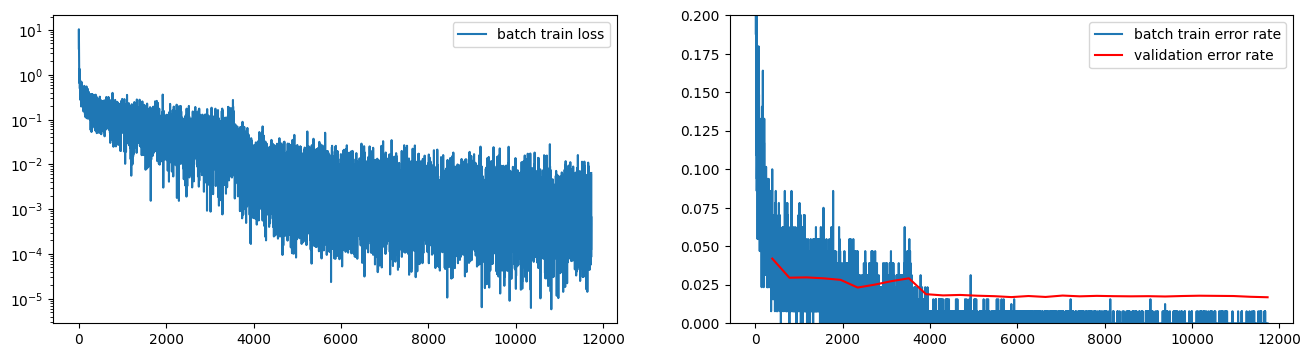

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    # 1 input layer 28*28=784 -> 400, 3 hidden layers 400->400, 1 out layer, 400->10
    nn.Linear(28*28, 1024),
    nn.ReLU(),


    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),



    nn.Linear(1024, 10)
    )

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            torch.nn.init.kaiming_normal_(p, mode='fan_in', nonlinearity='relu') # Kaiming uniform distribution, also known as He initialization
            # p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=0.1, num_epochs=30 ,max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

----------------------------------------------------------
After epoch 30 | valid err rate:  0.95% | doing  37 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 24)

-------------------------------------------
Test error rate: 0.950%, training took 51s.
-------------------------------------------


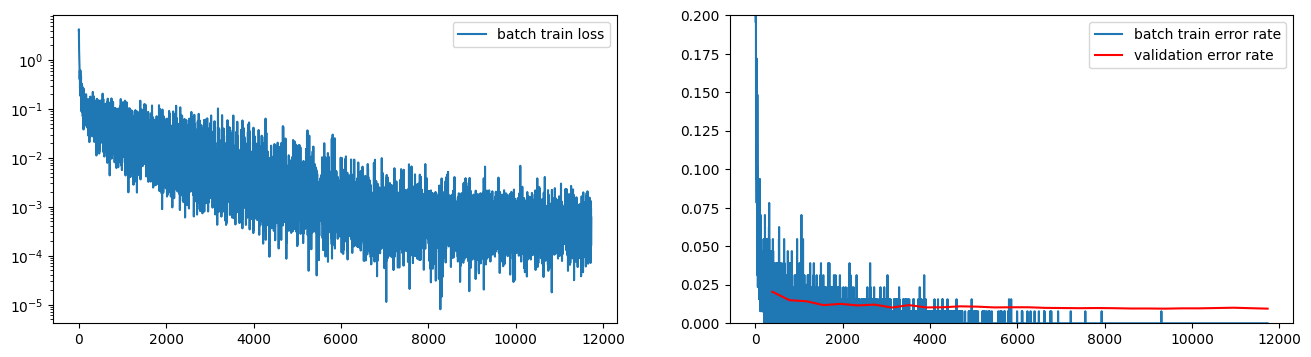

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(

    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # 1x28x28 -> 32x28x28
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 32x28x28 -> 32x14x14

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 32x14x14 -> 64x14x14
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 64x14x14 -> 64x7x7


    nn.Flatten(),

    nn.Linear(64 * 7 * 7, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
    )

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            torch.nn.init.kaiming_normal_(p, mode='fan_in', nonlinearity='relu')
            # p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.1, num_epochs=30 ,max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.


----------------------------------------------------------
After epoch 30 | valid err rate:  1.33% | doing  37 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 24)

---------------------------------------------
Test error rate: 1.420%, training took 1406s.
---------------------------------------------


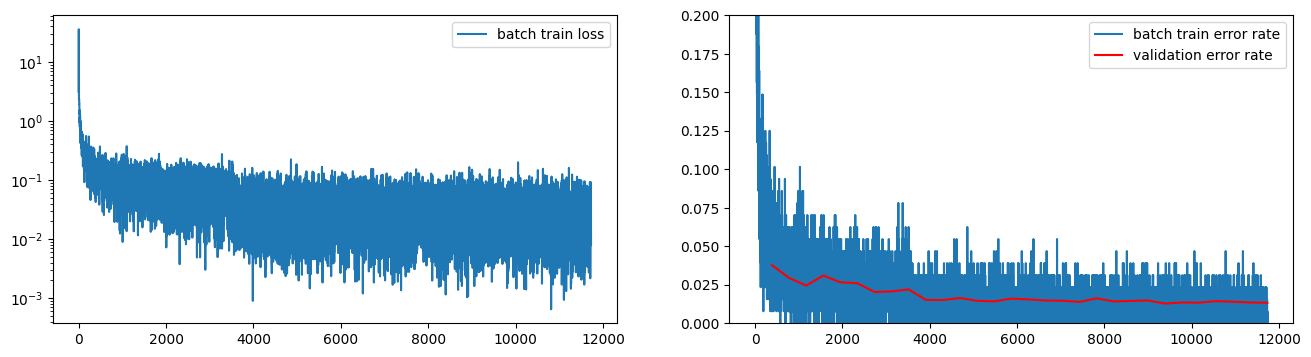

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(

    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # 1x28x28 -> 32x28x28
    nn.BatchNorm2d(32),  #after conv layer before activation
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 32x28x28 -> 32x14x14

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 32x14x14 -> 64x14x14
    nn.BatchNorm2d(64),  #after conv layer before activation
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # 64x14x14 -> 64x7x7


    nn.Flatten(),

    nn.Linear(64 * 7 * 7, 100),
    # nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
    )

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name and len(p.shape) >= 2:
            torch.nn.init.kaiming_normal_(p, mode='fan_in', nonlinearity='relu')
            # p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        # else:
        #     raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.1, num_epochs=30 ,max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

In [ ]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    #
    # TODO for Problem 2.2: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(param) for param in model.parameters()]
    #
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #
            # from 0.1 to 0.01 linear in epoch 10
            # from 0.01 to 0.005 in epoch 11
            # decay = (0.1 - 0.01) / (10 - 1)
            # if epoch == 11:
              # alpha = alpha / 2
            # alpha = max(0.005, alpha - decay)
            if epoch == 10:
              alpha = 0.01

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)

                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        # if "weight" in name:
                            #weight decay, lambda is 1e-4 (more precisely, lambda is (1e-4)/2, because we add 2*lambda*p)
                            # p.grad += 1e-4 * p
                            # no weight decay
                        if "weight" in name and len(p.shape) >= 2:
                          # calculate row norm for every row in matrix of weights, se we get a list of fe 400 norms
                            row_norms = p.norm(p=2, dim=1, keepdim=True)
                            # we 'clamp', if some val in rownorms > 3 then 3
                            desired = torch.clamp(row_norms, max=3)
                            # we multiply every row of p by desired/rownorms
                            p.mul_(desired / (row_norms + 1e-7))


                        # momentum, momentum parameter is 0.9
                        epsilon = 0.9
                        v[...] = epsilon * v - alpha * p.grad
                        p += v

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(
    nn.Linear(28*28, 400),
    nn.ReLU(),
    nn.Linear(400, 400),
    nn.ReLU(),
    nn.Linear(400, 400),
    nn.ReLU(),
    nn.Linear(400, 400),
    nn.ReLU(),
    nn.Linear(400, 10)
    )

with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            torch.nn.init.kaiming_normal_(p, mode='fan_in', nonlinearity='relu')
            # p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.1, num_epochs=30 ,max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

Training the model!
Interrupt at any time to evaluate the best validation model so far.
tensor([[1.4126],
        [1.4815],
        [1.4062],
        [1.4097],
        [1.4303],
        [1.3597],
        [1.4408],
        [1.4489],
        [1.4037],
        [1.3910],
        [1.3589],
        [1.3570],
        [1.4567],
        [1.4407],
        [1.4440],
        [1.4562],
        [1.4248],
        [1.3852],
        [1.4265],
        [1.3788],
        [1.4853],
        [1.3896],
        [1.4580],
        [1.3896],
        [1.4430],
        [1.3908],
        [1.3773],
        [1.4125],
        [1.4116],
        [1.4037],
        [1.3800],
        [1.3725],
        [1.4071],
        [1.3632],
        [1.4220],
        [1.3993],
        [1.4352],
        [1.3914],
        [1.3826],
        [1.4322],
        [1.5111],
        [1.4182],
        [1.4669],
        [1.4283],
        [1.4344],
        [1.4117],
        [1.3852],
        [1.4041],
        [1.3686],
        [1.3300],
        [1.3

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

In [ ]:
class Model(nn.Module):
    def __init__(self,num_neurons, dropout_rate):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(28*28, num_neurons),
          nn.ReLU(),
          nn.Linear(num_neurons, num_neurons),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(num_neurons, num_neurons),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(num_neurons, num_neurons),
          nn.ReLU(),
          nn.Linear(num_neurons, 10)
        )

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


def train_model(model, data_loaders, optimizer, max_epochs, device):
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    model.train()
    model.to(device)

    for epoch in range(max_epochs):
        for x, y in data_loaders["train"]:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = model.loss(out, y)
            loss.backward()
            optimizer.step()

        val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
        history["val_errs"].append(val_err_rate)
        print(f"Epoch {epoch+1}/{max_epochs}: Validation error: {val_err_rate*100:.2f}%")
    return history


def hyperparameter_tuner(data_loaders, device="cuda", trials=20, max_epochs=10):
    best_val_err = float('inf')
    best_hyperparams = None

    for trial in range(trials):
        alpha = 10 ** np.random.uniform(-5, -1) # od 0.1 do 0.00001 randomowo
        neurons = np.random.choice([100,200,400,800,1200])
        dropout_rate = np.random.uniform(0, 0.5)
        momentum = np.random.uniform(0.8, 0.95)

        print(f"Trial {trial+1}: alpha={alpha:.5f}, neurons={neurons}, dropout={dropout_rate:.2f}, momentum={momentum}")

        model = Model(num_neurons=neurons, dropout_rate=dropout_rate)

        optimizer = torch.optim.SGD(model.parameters(), lr=alpha, momentum=momentum)
        history = train_model(model, data_loaders, optimizer, max_epochs, device)
        valerr = history['val_errs'][-1]

        if valerr < best_val_err:
            best_val_err = valerr
            best_hyperparams = {'alpha': alpha, 'neurons': neurons, 'dropout': dropout_rate, 'momentum': momentum}

    print(f"Best hyperparameters: {best_hyperparams}")
    print(f"Best validation error: {best_val_err}")
    return best_hyperparams

best_hyperparams = hyperparameter_tuner(mnist_loaders)







Trial 1: alpha=0.00015, neurons=1200, dropout=0.44, momentum=0.8517586394402863
Epoch 1/10: Validation error: 84.46%
Epoch 2/10: Validation error: 67.71%
Epoch 3/10: Validation error: 50.00%
Epoch 4/10: Validation error: 41.62%
Epoch 5/10: Validation error: 39.34%
Epoch 6/10: Validation error: 40.08%
Epoch 7/10: Validation error: 41.71%
Epoch 8/10: Validation error: 41.96%
Epoch 9/10: Validation error: 39.89%
Epoch 10/10: Validation error: 35.67%
Trial 2: alpha=0.00290, neurons=100, dropout=0.02, momentum=0.8678771722661451
Epoch 1/10: Validation error: 29.95%
Epoch 2/10: Validation error: 10.54%
Epoch 3/10: Validation error: 8.45%
Epoch 4/10: Validation error: 7.41%
Epoch 5/10: Validation error: 5.53%
Epoch 6/10: Validation error: 4.92%
Epoch 7/10: Validation error: 4.15%
Epoch 8/10: Validation error: 3.99%
Epoch 9/10: Validation error: 3.63%
Epoch 10/10: Validation error: 3.59%
Trial 3: alpha=0.00041, neurons=400, dropout=0.44, momentum=0.8193362947307267
Epoch 1/10: Validation error